In [ ]:
!pip install --upgrade pip
!pip install tokenizers
!pip install datasets --upgrade evaluate
!pip install transformers
!pip install numpy torch matplotlib pandas scikit-learn tqdm pillow
!pip install datasets evaluate transformers
!pip install torchvision
!pip install setuptools
!pip install wandb
!pip show wandb
!pip install schedulefree
!pip install nbformat

Name: wandb
Version: 0.19.9
Summary: A CLI and library for interacting with the Weights & Biases API.
Home-page: 
Author: 
Author-email: Weights & Biases <support@wandb.com>
License: MIT License

Copyright (c) 2021 Weights and Biases, Inc.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEM

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from evaluate import load
from transformers import (
    ViTFeatureExtractor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer,
    get_scheduler,
    AutoImageProcessor
)

from torch.optim import AdamW, SGD
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torchvision.transforms as transforms
from PIL import Image
import random
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from schedulefree import AdamWScheduleFree
from torch.optim.lr_scheduler import CyclicLR, ExponentialLR, ReduceLROnPlateau
from transformers import TrainerCallback, EarlyStoppingCallback
from scipy.ndimage import zoom
import os
import re
from PIL import Image

In [ ]:
class Attentionmapcallback(TrainerCallback):
    def __init__(self, feature_extractor, image, output_dir,total_epochs,steps_tune, device = 'cuda'):
        self.feature_extractor = feature_extractor
        self.image = image
        self.output_dir = output_dir
        self.total_epochs = total_epochs
        self.device = device
        self.steps_tune = steps_tune
        os.makedirs(self.output_dir, exist_ok=True)

    def plt_attn(self, attentions, epoch, step , layer = 0, head = 0):

      attn = attentions[layer][0,head]  #.cpu().detach().numpy()
      cls_attn = attn[0,1:]
      nm_patch = cls_attn.shape[0]
      gid_size = int(np.sqrt(nm_patch))
      ##cls_attn = cls_attn.reshape(gid_size,gid_size)

      if gid_size * gid_size != nm_patch:
        print(f"skipping attn epoch {epoch}")
        return

      cls_attn = cls_attn.cpu().detach().numpy().reshape(gid_size,gid_size)

      if isinstance(self.image, np.ndarray):
        img_np = self.image
      else:
        img_np = np.array(self.image)

      attn_resized = zoom(cls_attn, (img_np.shape[0] / gid_size, img_np.shape[1] / gid_size))

      plt.figure(figsize=(8, 8))


      plt.imshow(self.image)

      plt.imshow(attn_resized, cmap = 'jet',  alpha=0.3)

      plt.axis('off')
      plt.title(f"Epoch {epoch}, Layer {layer}, Head {head}")
      plt.savefig(os.path.join(self.output_dir, f"step_{step}_epoch_{epoch}_layer_{layer}_head_{head}.png"))
      plt.close()



    def on_step_end(self, args, state, control, **kwargs):
      epoch = state.epoch
      step = state.global_step
      if step in self.steps_tune:
        model = kwargs['model']
        model.eval()
        inputs = self.feature_extractor(images=self.image, return_tensors="pt").to(self.device)
        with torch.no_grad():
          outputs = model(**inputs, output_attentions=True)
          attentions = outputs.attentions
          #self.plt_attn(attentions, int(epoch), int(step))
          self.plt_attn(attentions, int(epoch), int(step) ,layer = -1, head = -1)



In [ ]:
class Attentionmapcallback_optsweep(TrainerCallback):
    def __init__(self, feature_extractor, image_grp, output_dir,total_epochs,steps_tune, device = 'cuda'):
        self.feature_extractor = feature_extractor
        self.image_grp = image_grp
        self.output_dir = output_dir
        self.total_epochs = total_epochs
        self.device = device
        self.steps_tune = steps_tune
        os.makedirs(self.output_dir, exist_ok=True)

    def plt_attn(self, attentions, epoch, step, img , layer = 0, head = 0, labl = "alt"):

      attn = attentions[layer][0,head]  #.cpu().detach().numpy()
      cls_attn = attn[0,1:]
      nm_patch = cls_attn.shape[0]
      gid_size = int(np.sqrt(nm_patch))
      ##cls_attn = cls_attn.reshape(gid_size,gid_size)

      if gid_size * gid_size != nm_patch:
        print(f"skipping attn epoch {epoch}")
        return

      cls_attn = cls_attn.cpu().detach().numpy().reshape(gid_size,gid_size)

      if isinstance(img, np.ndarray):
        img_np = img
      else:
        img_np = np.array(img)

      attn_resized = zoom(cls_attn, (img_np.shape[0] / gid_size, img_np.shape[1] / gid_size))

      plt.figure(figsize=(8, 8))


      plt.imshow(img)

      plt.imshow(attn_resized, cmap = 'jet',  alpha=0.3)
      output_dir_mod = self.output_dir + "/" + str(labl)
      # print("output_dir_mod")
      # print(output_dir_mod)
      os.makedirs(output_dir_mod, exist_ok=True)


      plt.axis('off')
      plt.title(f"Epoch {epoch}, Layer {layer}, Head {head}, Label{labl}")
      plt.savefig(os.path.join(output_dir_mod, f"step_{step}_epoch_{epoch}_layer_{layer}_head_{head}.png"))
      plt.close()



    def on_step_end(self, args, state, control, **kwargs):
      epoch = state.epoch
      step = state.global_step
      if step in self.steps_tune:
        model = kwargs['model']
        model.eval()
       # print(self.image_grp)
        for i in range(len(self.image_grp['image'])):
          img = self.image_grp['image'][i]
          lbl = self.image_grp['label'][i]
          inputs = self.feature_extractor(images=img, return_tensors="pt").to(self.device)
          with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            attentions = outputs.attentions
            #self.plt_attn(attentions, int(epoch), int(step))
            self.plt_attn(attentions, int(epoch), int(step), img ,layer = -1, head = -1, labl = lbl)



In [ ]:
def stp_extrct(fname):
  match = re.search(r'step_(\d+)_epoch_(\d+)', fname)
  return int(match.group(1)) if match else flat('inf')

def make_log_fig(step_func,num_epoch, sch_name, opt_name, data_for_img):

  # for i in range(num_epoch):
  #   for j in step_func:
  #     img_addr = './attention_maps/' + str(sch_name).split('.')[-1] + "_" + str(opt_name).split('.')[-1] + "/" + "step_" + str(j) + "_epoch_" + str(i) + "_layer_-1_head_-1.png"
  #     img_files.append(img_addr)
  print(data_for_img)
  for i in range(len(data_for_img['label'])):

    img_files = []

    img_files_names = os.listdir('./attention_maps/' + str(sch_name).split('.')[-1] + "_" + str(opt_name).split('.')[-1] + "/" + str(data_for_img["label"][i]))
    img_files_names.sort(key=stp_extrct)
    print("img_files_names")
    print(img_files_names)
    for j in img_files_names:
      img_addr = './attention_maps/' + str(sch_name).split('.')[-1] + "_" + str(opt_name).split('.')[-1] + "/" + str(data_for_img["label"][i]) +  "/" + str(j)
      img_files.append(img_addr)


    images = [Image.open(file) for file in img_files]
    min_height = min(img.height for img in images)
    images = [img.resize((img.width, min_height)) for img in images]
    total_width = sum(img.width for img in images)
    result = Image.new('RGB', (total_width, min_height))
    x_offset = 0
    for img in images:
        result.paste(img, (x_offset, 0))
        x_offset += img.width

    output_path = './attention_maps/' + str(sch_name).split('.')[-1] + "_" + str(opt_name).split('.')[-1] + "_" + str(data_for_img["label"][i]) + "attn_images.png"

    result.save(output_path)
    logimg = "attn_image_" + str(sch_name).split('.')[-1] + "_" + str(opt_name).split('.')[-1] + "_" + str(data_for_img["label"][i])

    wandb.log({logimg: wandb.Image(output_path)})

In [ ]:
# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

# Initialize experiment tracking
def init_wandb(project_name, experiment_name, config):
    return wandb.init(
        # entity="dl_project_sp25",
        project=project_name,
        name=experiment_name,
        config=config,
        reinit=True
    )

# Load and prepare dataset
def prepare_dataset(dataset_name, image_processor, row_indx):
    """
    Load and prepare a dataset from Hugging Face for ViT fine-tuning
    """
    # Load the dataset
    print(f"Loading dataset: {dataset_name}")
    dataset = load_dataset(dataset_name)

    # Get label information
    if "label" in dataset["train"].features:
        labels = dataset["train"].features["label"].names
    elif "labels" in dataset["train"].features:
        labels = dataset["train"].features["labels"].names
    else:
        # Count unique labels and create labels list
        all_labels = dataset["train"][0]["label"] if "label" in dataset["train"][0] else dataset["train"][0]["labels"]
        num_labels = len(set(all_labels))
        labels = [str(i) for i in range(num_labels)]

    # Create label mappings
    label2id = {label: i for i, label in enumerate(labels)}
    id2label = {i: label for i, label in enumerate(labels)}

    # Set up image transformations based on the model's requirements
    normalize = transforms.Normalize(
        mean=image_processor.image_mean,
        std=image_processor.image_std
    )

    # Get the expected image size
    if "shortest_edge" in image_processor.size:
        size = image_processor.size["shortest_edge"]
    else:
        size = (image_processor.size["height"], image_processor.size["width"])

    # Define transforms for training data
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    # Define transforms for validation/test data
    val_transforms = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        normalize,
    ])

    # Apply transformations to the dataset
    def preprocess_train(examples):
        examples["pixel_values"] = [
            train_transforms(image.convert("RGB"))
            for image in examples["image"]
        ]
        return examples

    def preprocess_val(examples):
        examples["pixel_values"] = [
            val_transforms(image.convert("RGB"))
            for image in examples["image"]
        ]
        return examples

    # taking the image out for attention_mp
    #####Adding the row index for the image you want to get the attention map for
    data_for_img = dataset["train"][row_indx]

    # Apply preprocessing to each split
    train_dataset = dataset["train"].map(
        preprocess_train, batched=True, remove_columns=["image"]
    )

    if "validation" in dataset:
        val_dataset = dataset["validation"].map(
            preprocess_val, batched=True, remove_columns=["image"]
        )

    else:
        # Create a validation split if none exists
        splits = train_dataset.train_test_split(test_size=0.2, seed=42)
        train_dataset = splits["train"]
        val_dataset = splits["test"]

    if "test" in dataset:
        test_dataset = dataset["test"].map(
            preprocess_val, batched=True, remove_columns=["image"]
        )
    else:
        # test_dataset = val_dataset    #split further rather than using validation as test dataset

        # Further split validation dataset to create a test dataset
        test_split = val_dataset.train_test_split(test_size=0.2, seed=42)
        val_dataset = test_split["train"]  # Update validation dataset
        test_dataset = test_split["test"]  # Create test dataset

    print(f"Dataset prepared with {len(train_dataset)} training, {len(val_dataset)} validation, and {len(test_dataset)} test examples")

    return train_dataset, val_dataset, test_dataset, id2label, label2id, data_for_img

# Define compute_metrics function for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

# Main experiment pipeline
def run_vit_experiment(config):
    """
    Run a ViT experiment with the specified configuration
    """
    # Initialize wandb for experiment tracking
    # run = init_wandb("ViT-LR-Schedulers", config["experiment_name"], config)

    # Initialize wandb for experiment tracking with config logging
    run = wandb.init(
        project="ViT-LR-Schedulers-attn4",
        name=config["experiment_name"],
        group=f"{config['optimizer_name']}_experiments",  # Group by optimizer
        config={
            # Explicitly list all important hyperparameters
            "optimizer": config["optimizer_name"],
            "scheduler": config["scheduler_name"],
            "learning_rate": config["learning_rate"],
            "batch_size": config["batch_size"],
            "num_epochs": config["num_epochs"],
            "weight_decay": config["weight_decay"],
            "warmup_ratio": config.get("warmup_ratio", 0.0),
            "dataset": config["dataset_name"],
            "model": config["model_name"],
            "row_indx" : config["row_indx"],
            "attention_steps": config["attention_steps"]
        },
        tags=[tag for tag in [config["optimizer_name"], config["scheduler_name"]] if tag is not None],
        reinit=True
    )


    # Load the image processor for the model
    image_processor = AutoImageProcessor.from_pretrained(config["model_name"], use_fast=True)

    # Prepare the dataset
    train_dataset, val_dataset, test_dataset, id2label, label2id, data_for_img = prepare_dataset(
        config["dataset_name"], image_processor, config["row_indx"]
    )

    # Load the ViT model
    model = ViTForImageClassification.from_pretrained(
        config["model_name"],
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/{config['experiment_name']}",
        per_device_train_batch_size=config["batch_size"],
        per_device_eval_batch_size=config["batch_size"],
        num_train_epochs=config["num_epochs"],
        weight_decay=config["weight_decay"],
        eval_strategy="steps",
        save_strategy="steps",
        logging_strategy="steps",  # Ensure logging is enabled
        logging_steps=10,          # Log every 10 steps (adjust as needed)
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        push_to_hub=False,
        report_to="wandb",
        remove_unused_columns=False,
        learning_rate=config["learning_rate"],
    )

    # Setup optimizer
    # if config["optimizer_name"] == "AdamW":
    #     optimizer = AdamW(model.parameters(), lr=config["learning_rate"])
    # else:  # SGD
    #     optimizer = SGD(model.parameters(), lr=config["learning_rate"], momentum=0.9)

    # Full run, 10 epoch set up.
    if config["optimizer_name"] == "schedule_free_adamw":
        optimizer = AdamWScheduleFree(model.parameters(), lr=config["learning_rate"])
        scheduler = None  # No external scheduler
    elif config["optimizer_name"] == "AdamW":
        optimizer = AdamW(model.parameters(), lr=config["learning_rate"])
    elif config["optimizer_name"] == "SGD":
        optimizer = SGD(model.parameters(), lr=config["learning_rate"], momentum=0.9)
    elif config["optimizer_name"] == "RMSProp":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=config["learning_rate"])
    elif config["optimizer_name"] == "AdaGrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr=config["learning_rate"])
    else:
        raise ValueError(f"Optimizer {config['optimizer_name']} not supported")

    # Setup scheduler
    num_training_steps = len(train_dataset) // config["batch_size"] * config["num_epochs"]
    num_warmup_steps = int(num_training_steps * config["warmup_ratio"]) if "warmup_ratio" in config else 0

    scheduler_name = config["scheduler_name"]

    if scheduler_name is None:
        scheduler = None    # Handle the case for schedule_free

    elif scheduler_name == "linear":
        scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )
    elif scheduler_name == "cosine":
        scheduler = get_scheduler(
            "cosine",
            optimizer=optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )

    elif scheduler_name == "polynomial":
        scheduler = get_scheduler(
            "polynomial",
            optimizer=optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps,
            # power=config.get("poly_power", 1.0),
        )
    elif scheduler_name == "cyclic":
        # CyclicLR from torch.optim.lr_scheduler
        # Using step_size_up as 1/3 of training steps and step_size_down as 2/3
        step_size_up = num_training_steps // 3
        scheduler = CyclicLR(
            optimizer,
            base_lr=config["learning_rate"] / 10,  # Lower bound of cycle
            max_lr=config["learning_rate"],       # Upper bound of cycle
            step_size_up=step_size_up,
            step_size_down=step_size_up * 2,
            mode='triangular',                    # Three modes: triangular, triangular2, exp_range
            cycle_momentum=False                  # Don't cycle momentum
        )
    elif scheduler_name == "exponential":
        # ExponentialLR from torch.optim.lr_scheduler
        # gamma < 1.0 for decay, common values: 0.9, 0.95, 0.99
        scheduler = ExponentialLR(optimizer, gamma=0.95)

    # elif scheduler_name == "adaptive":
    #     # ReduceLROnPlateau - reduces LR when metric stops improving
    #     # This requires modification to the training loop to update based on validation performance
    #     scheduler = ReduceLROnPlateau(
    #         optimizer,
    #         mode='max',              # Since we want to maximize accuracy
    #         factor=0.5,              # Multiply LR by this factor when plateauing
    #         patience=2,              # Number of epochs with no improvement after which LR will be reduced
    #         threshold=0.01,          # Threshold for measuring improvement
    #         threshold_mode='rel',    # Interpret threshold as relative change
    #         min_lr=1e-6              # Lower bound on the learning rate
    #     )

    elif scheduler_name == "constant":
        scheduler = get_scheduler(
            "constant",
            optimizer=optimizer,
        )
    elif scheduler_name == "cosine_with_restarts":
        scheduler = get_scheduler(
            "cosine_with_restarts",
            optimizer=optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps,
        )
    elif scheduler_name == "constant_with_warmup":
        scheduler = get_scheduler(
            "constant_with_warmup",
            optimizer=optimizer,
            num_warmup_steps=num_warmup_steps,
        )
    # add more experiments if required ...

    else:
        raise ValueError(f"Scheduler {scheduler_name} not supported")
    # print(config)
    # print(config.keys())
    # print(config.optimizer_name)
    # Initialize attention callback (self, feature_extractor, image, output_dir,total_epochs,steps_tune, device = 'cuda'):
    # print(config['optimizer_name'])
    # print(scheduler_name)
    # print(config["attention_steps"])
    # plt.imshow(data_for_img['image'])
    attn_map_clbck = Attentionmapcallback(image_processor,
                                  data_for_img['image'],
                                  './attention_maps/' + str(scheduler_name).split('.')[-1] + "_" + str(config['optimizer_name']).split('.')[-1],
                                  training_args.num_train_epochs,
                                  steps_tune = config["attention_steps"])

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler),
        callbacks = [attn_map_clbck]

    )

    # # Loss validation curve in the training loop to log metrics to W&B
    # for epoch in range(config["num_epochs"]):
    #     print(f"Epoch {epoch + 1}/{config['num_epochs']}")

    #     # Train for one epoch
    #     trainer.train()

    #     # Evaluate on validation set
    #     eval_results = trainer.evaluate(val_dataset)

    #     print(trainer.state.log_history)
    #     if trainer.state.log_history and "loss" in trainer.state.log_history[-1]:
    #         train_loss = trainer.state.log_history[-1]["loss"]
    #     else:
    #         train_loss = None

    #     # Log training and validation metrics to W&B
    #     wandb.log({
    #         "epoch": epoch + 1,
    #         "train_loss": trainer.state.log_history[-1].get("loss", None),
    #         "val_loss": eval_results["eval_loss"],
    #         "val_accuracy": eval_results["eval_accuracy"],
    #     })

    # # Loss epoch curve in the training loop to log metrics to W&B
    # for epoch in range(config["num_epochs"]):
    #     print(f"Epoch {epoch + 1}/{config['num_epochs']}")

    #     # Train for one epoch
    #     trainer.train()

    #     # Evaluate on validation set
    #     eval_results = trainer.evaluate(val_dataset)

    #     # Extract training loss from the trainer's state
    #     if trainer.state.log_history and "loss" in trainer.state.log_history[-1]:
    #         train_loss = trainer.state.log_history[-1]["loss"]
    #     else:
    #         train_loss = None  # Handle missing loss gracefully

    #     # Log training and validation metrics to W&B
    #     wandb.log({
    #         "epoch": epoch + 1,
    #         "train_loss": train_loss,                  # Training loss
    #         "val_loss": eval_results["eval_loss"],    # Validation loss
    #         "val_accuracy": eval_results["eval_accuracy"],  # Validation accuracy
    #     })

    # Train the model
    print(f"Starting training for {config['experiment_name']}...")
    trainer.train()

    # Evaluate the model
    print(f"Evaluating {config['experiment_name']}...")
    eval_results = trainer.evaluate(test_dataset)


    # Log final metrics
    wandb.log({
        "final_accuracy": eval_results["eval_accuracy"],
        "final_f1": eval_results["eval_f1"],
        "final_precision": eval_results["eval_precision"],
        "final_recall": eval_results["eval_recall"],
    })

    # Compute confusion matrix for test set
    predictions, labels, _ = trainer.predict(test_dataset)
    predictions = np.argmax(predictions, axis=1)

    # Convert to lists
    labels = labels.tolist()
    predictions = predictions.tolist()

    # Log confusion matrix to W&B
    wandb.log({
        "confusion_matrix_test": wandb.plot.confusion_matrix(
            probs=None,
            y_true=labels,
            preds=predictions,
            class_names=[str(i) for i in range(len(np.unique(labels)))]
        )
    })



    # Save the model
    trainer.save_model(f"./saved_models/{config['experiment_name']}")

    # logging attention maps
    make_log_fig(config['attention_steps'], config['num_epochs'], config['scheduler_name'], config['optimizer_name'])

    # Finish wandb run
    # wandb.finish()

    return eval_results

# Get experiment configurations for challenging datasets
def get_experiment_configs():
    # We'll use a more complex dataset from Hugging Face
    base_config = {
        "model_name": "google/vit-base-patch16-224-in21k",
        "dataset_name": "jbarat/plant_species",  # Any challenging dataset.
        "batch_size": 16,
        "num_epochs": 10, # let's keep smaller number to begin with.
        "weight_decay": 0.01,
        "attention_steps" : [5, 10, 15, 50,100,200,300,400,500],
        "row_indx" : [60,100,150,200,250,300,350,400,450,500,550,600,650,700],
        # "optimizer_name": "AdamW",
    }

    # Optimizers with their corresponding learning rates
    optimizers = {
        # "schedule_free_adamw": 0.0002,    #Lets get this separately.
        # "AdamW": 0.0002,
        # "RMSProp": 0.0002,
        "AdaGrad": 0.0002,
        "SGD": 0.02,
    }

    # Schedulers to test
    schedulers = [
        "linear",
        "cosine",
        "polynomial",
        "cyclic",
        "exponential",
        # "adaptive",
        "constant",
        "cosine_with_restarts",
        "constant_with_warmup",

    ]



    # Different learning rate scheduler configurations
    configs = []

    # # Constant learning rate (baseline)
    # configs.append({
    #     **base_config,
    #     "experiment_name": "vit_constant_lr",
    #     "learning_rate": 2e-4,
    #     "scheduler_name": "constant",
    # })

    # # Add a schedule-free-only experiment
    # configs.append({
    #     **base_config,
    #     "experiment_name": "schedule_free_adamw_no_scheduler",
    #     "optimizer_name": "schedule_free_adamw",
    #     "learning_rate": 0.0002,
    #     "scheduler_name": None,  # Explicitly set to None
    # })


    for optimizer_name, learning_rate in optimizers.items():
        for scheduler_name in schedulers:
            config = {
                **base_config,
                "experiment_name": f"{optimizer_name}_{scheduler_name}",
                "optimizer_name": optimizer_name,
                "learning_rate": learning_rate,
                "scheduler_name": scheduler_name,
                "warmup_ratio": 0.1,  # Keep warmup ratio consistent
            }
            configs.append(config)


    # # Cosine with restarts
    # configs.append({
    #     **base_config,
    #     "experiment_name": "vit_cosine_restarts",
    #     "learning_rate": 2e-4,
    #     "scheduler_name": "cosine_with_restarts",
    #     "warmup_ratio": 0.1,
    # })

    # # Constant with warmup
    # configs.append({
    #     **base_config,
    #     "experiment_name": "vit_constant_warmup",
    #     "learning_rate": 2e-4,
    #     "scheduler_name": "constant_with_warmup",
    #     "warmup_ratio": 0.1,
    # })

    # # Linear decay
    # configs.append({
    #     **base_config,
    #     "experiment_name": "vit_linear_decay",
    #     "learning_rate": 5e-5,
    #     "scheduler_name": "linear",
    #     "warmup_ratio": 0.1,
    # })

    # # Cosine decay (commonly used with ViT)
    # configs.append({
    #     **base_config,
    #     "experiment_name": "vit_cosine_decay",
    #     "learning_rate": 5e-5,
    #     "scheduler_name": "cosine",
    #     "warmup_ratio": 0.1,
    # })


    # # Polynomial decay
    # configs.append({
    #     **base_config,
    #     "experiment_name": "vit_polynomial",
    #     "learning_rate": 5e-5,
    #     "scheduler_name": "polynomial",
    #     "warmup_ratio": 0.1,
    #     "poly_power": 2.0,
    # })


    # # Different learning rate experiments
    # for lr in [1e-5, 3e-5, 1e-4]:
    #     configs.append({
    #         **base_config,
    #         "experiment_name": f"vit_cosine_lr_{lr}",
    #         "learning_rate": lr,
    #         "scheduler_name": "cosine",
    #         "warmup_ratio": 0.1,
    #     })

    # # Different optimizer experiments
    # configs.append({
    #     **base_config,
    #     "experiment_name": "vit_sgd_cosine",
    #     "learning_rate": 0.01,  # Higher LR for SGD
    #     "scheduler_name": "cosine",
    #     "warmup_ratio": 0.1,
    #     "optimizer_name": "SGD",
    # })

    # here we can make changes to add new datasets to experiment.
    # or change batch_size to see the impact.
    # Other datasets to try (uncomment to use)
    #   Erik: We can use a data set as a strech. Maybe something less similar than plants for better contrasting comparison?
    # flowers dataset
    # configs.append({
    #     **base_config,
    #     "dataset_name": "huggan/flowers",
    #     "experiment_name": "vit_flowers_cosine",
    #     "learning_rate": 5e-5,
    #     "scheduler_name": "cosine",
    #     "warmup_ratio": 0.1,
    # })

    return configs

# Run experiments and visualize results
def run_all_experiments():
    configs = get_experiment_configs()
    results = []

    for config in configs:
        print(f"\n{'='*50}")
        print(f"Running experiment: {config['experiment_name']}")
        print(f"{'='*50}\n")

        eval_results = run_vit_experiment(config)
        results.append({
            "experiment": config['experiment_name'],
            "accuracy": eval_results["eval_accuracy"],
            "f1": eval_results["eval_f1"],
            "precision": eval_results["eval_precision"],
            "recall": eval_results["eval_recall"],
            "config": config
        })

    # Make sure to close the final run
    if wandb.run is not None:
        wandb.finish()

    return results

# Visualize and compare results
def visualize_results(results):
    # Create DataFrame for easier plotting
    df = pd.DataFrame([
        {
            "Experiment": result["experiment"],
            "Accuracy": result["accuracy"],
            "F1 Score": result["f1"],
            "Precision": result["precision"],
            "Recall": result["recall"],
            "Learning Rate": result["config"]["learning_rate"],
            "Scheduler": result["config"]["scheduler_name"],
            "Optimizer": result["config"]["optimizer_name"],
            "Dataset": result["config"]["dataset_name"]
        }
        for result in results
    ])

    # Plot accuracy comparison
    plt.figure(figsize=(14, 8))
    ax = plt.bar(df["Experiment"], df["Accuracy"], color='skyblue')
    plt.xlabel('Experiment')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Model Accuracy Across Experiments')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("accuracy_comparison.png")
    plt.close()

    # Plot all metrics for a more comprehensive comparison
    plt.figure(figsize=(16, 10))
    metrics = ["Accuracy", "F1 Score", "Precision", "Recall"]
    x = np.arange(len(df["Experiment"]))
    width = 0.2

    for i, metric in enumerate(metrics):
        plt.bar(x + i*width, df[metric], width=width, label=metric)

    plt.xlabel('Experiment')
    plt.ylabel('Score')
    plt.title('Comparison of Metrics Across Experiments')
    plt.xticks(x + width*1.5, df["Experiment"], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig("metrics_comparison.png")
    plt.close()

    # Plot results by scheduler type
    plt.figure(figsize=(14, 8))
    schedulers = df["Scheduler"].unique()
    for scheduler in schedulers:
        scheduler_data = df[df["Scheduler"] == scheduler]
        plt.plot(scheduler_data["Learning Rate"], scheduler_data["Accuracy"], 'o-', label=scheduler)

    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Learning Rate by Scheduler Type')
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("scheduler_comparison.png")
    plt.close()

    # Create a table with results
    print("Results Summary:")
    print(df[["Experiment", "Accuracy", "F1 Score", "Precision", "Recall", "Scheduler", "Learning Rate", "Optimizer", "Dataset"]])

    # Save results to CSV
    df.to_csv("experiment_results.csv", index=False)

    return df

# Function to run a single experiment (useful for testing)
def run_single_experiment(experiment_index=0):
    configs = get_experiment_configs()
    if experiment_index >= len(configs):
        print(f"Invalid experiment index. Choose between 0 and {len(configs)-1}")
        return

    config = configs[experiment_index]
    print(f"Running single experiment: {config['experiment_name']}")
    eval_results = run_vit_experiment(config)

    print(f"\nResults for {config['experiment_name']}:")
    print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
    print(f"F1 Score: {eval_results['eval_f1']:.4f}")
    print(f"Precision: {eval_results['eval_precision']:.4f}")
    print(f"Recall: {eval_results['eval_recall']:.4f}")

    return eval_results


In [ ]:
dataset_name = "jbarat/plant_species"
model_name = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
print(f"Loading dataset: {dataset_name}")
dataset = load_dataset(dataset_name)

# Get label information
if "label" in dataset["train"].features:
    labels = dataset["train"].features["label"].names
elif "labels" in dataset["train"].features:
    labels = dataset["train"].features["labels"].names
else:
    # Count unique labels and create labels list
    all_labels = dataset["train"][0]["label"] if "label" in dataset["train"][0] else dataset["train"][0]["labels"]
    num_labels = len(set(all_labels))
    labels = [str(i) for i in range(num_labels)]

# Create label mappings
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

# Set up image transformations based on the model's requirements
normalize = transforms.Normalize(
    mean=image_processor.image_mean,
    std=image_processor.image_std
)

# Get the expected image size
if "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
else:
    size = (image_processor.size["height"], image_processor.size["width"])

# Define transforms for training data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

# Define transforms for validation/test data
val_transforms = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(size),
    transforms.ToTensor(),
    normalize,
])

# Apply transformations to the dataset
def preprocess_train(examples):
    examples["pixel_values"] = [
        train_transforms(image.convert("RGB"))
        for image in examples["image"]
    ]
    return examples

def preprocess_val(examples):
    examples["pixel_values"] = [
        val_transforms(image.convert("RGB"))
        for image in examples["image"]
    ]
    return examples

# taking the image out for attention_mp
#####Adding the row index for the image you want to get the attention map for
#data_for_img = dataset["train"][row_indx]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading dataset: jbarat/plant_species


In [ ]:
dataset["train"][[60,150,250,350,450,550,600,700]]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=281x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>],
 'label': [0, 1, 2, 3, 4, 5, 6, 7]}

In [ ]:
chck = dataset["train"][[60,150,250,350,450,550,600,700]]
for i in range(len(chck['image'])):
  print(chck['image'][i])

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7A45AC3D1B90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7A45AC3D1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7A45AC3D22D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7A45AC3D2790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7A45AC3D2C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x500 at 0x7A45AC3D3150>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=281x500 at 0x7A45AC3D3590>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7A45AC3D3A10>


In [ ]:
chck

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=281x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>],
 'label': [0, 1, 2, 3, 4, 5, 6, 7]}

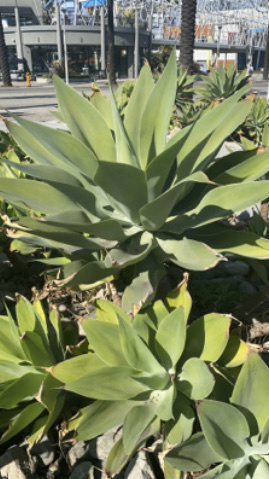

In [ ]:
dataset["train"][240]['image']

In [ ]:
# Uncomment to use: For 3 epoch sweep with only cosine scheduler to get best LR:
def run_optimizer_sweep():
    # Initialize W&B run first, then access config
    with wandb.init() as run:
        print(f"W&B initialized: {run.name}")

        # Get config from sweep
        config = wandb.config

        # Set experiment name based on sweep parameters
        custom_name = f"vit_{config.optimizer_name}_{config.learning_rate}"
        # Update the run name after initialization
        wandb.run.name = custom_name
        wandb.run.save()

        print(f"Running experiment: {custom_name}")

        # Load model and processor
        model_name = "google/vit-base-patch16-224-in21k"
        dataset_name = "jbarat/plant_species"

        # Load the image processor
        image_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)

        # Prepare dataset
        train_dataset, val_dataset, test_dataset, id2label, label2id, data_for_img = prepare_dataset(
            dataset_name, image_processor, config.row_indx
        )

        # print("data for img")
        # print(data_for_img)

        # Load the ViT model
        model = ViTForImageClassification.from_pretrained(
            model_name,
            num_labels=len(id2label),
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )

        # Define training arguments
        training_args = TrainingArguments(
            output_dir=f"./results/{custom_name}",
            per_device_train_batch_size=config.batch_size,
            per_device_eval_batch_size=config.batch_size,
            num_train_epochs=config.num_epochs,
            weight_decay=0.01,
            eval_strategy="steps",
            save_strategy="steps",
            logging_strategy="steps",
            logging_steps=10,
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            push_to_hub=False,
            report_to="wandb",
            remove_unused_columns=False,
            learning_rate=config.learning_rate,
        )

        # Set up optimizer based on config
        if config.optimizer_name == "schedule_free_adamw":
            optimizer = AdamWScheduleFree(
                model.parameters(),
                lr=config.learning_rate,  # Learning rate
                # warmup_steps=500  # Optional: Adjust based on your dataset
            )
        elif config.optimizer_name == "AdamW":
            optimizer = AdamW(model.parameters(), lr=config.learning_rate)
        elif config.optimizer_name == "SGD":
            optimizer = SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
        elif config.optimizer_name == "RMSProp":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=config.learning_rate)
        elif config.optimizer_name == "AdaGrad":
            optimizer = torch.optim.Adagrad(model.parameters(), lr=config.learning_rate)
        else:
            optimizer = AdamW(model.parameters(), lr=config.learning_rate)

        # Setup scheduler
        num_training_steps = len(train_dataset) // config.batch_size * config.num_epochs
        num_warmup_steps = int(num_training_steps * 0.1)  # 10% warmup

        if config.scheduler_name == "cyclic":
          lr = config.learning_rate
          step_size_up = num_training_steps // 3
          scheduler = CyclicLR(
              optimizer,
              base_lr= lr / 10,  # Lower bound of cycle
              max_lr= lr,       # Upper bound of cycle
              step_size_up=step_size_up,
              step_size_down=step_size_up * 2,
              mode='triangular',                    # Three modes: triangular, triangular2, exp_range
              cycle_momentum=False                  # Don't cycle momentum
          )


        elif config.scheduler_name == "exponential":
          # ExponentialLR from torch.optim.lr_scheduler
          # gamma < 1.0 for decay, common values: 0.9, 0.95, 0.99
          scheduler = ExponentialLR(optimizer, gamma=0.95)

        else:

          scheduler = get_scheduler(
              config.scheduler_name,
              optimizer=optimizer,
              num_warmup_steps=num_warmup_steps,
              num_training_steps=num_training_steps
          )


        # Initialize attention callback (self, feature_extractor, image, output_dir,total_epochs,steps_tune, device = 'cuda'):
        attn_map_clbck = Attentionmapcallback_optsweep(image_processor,
                                      data_for_img,
                                      './attention_maps/' + str(config.scheduler_name).split('.')[-1] + "_" + str(config.optimizer_name).split('.')[-1],
                                      training_args.num_train_epochs,
                                      steps_tune = config.attention_steps)


        # Initialize Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            optimizers=(optimizer, scheduler),
            callbacks = [attn_map_clbck]
        )

        # Train the model
        print(f"Starting training...")
        # optimizer.train()  # Switch optimizer to training mode only for schedule_free
        trainer.train()

        # Evaluate on validation dataset
        print(f"Evaluating on validation set...")
        # optimizer.eval()  # Switch optimizer to evaluation mode only for schedule_free
        eval_results = trainer.evaluate(val_dataset)

        # Log validation metrics
        run.log({
            "val_accuracy": eval_results["eval_accuracy"],
            "val_f1": eval_results["eval_f1"],
            "val_precision": eval_results["eval_precision"],
            "val_recall": eval_results["eval_recall"],
            "val_loss": eval_results["eval_loss"]
        })

        # Evaluate on test dataset
        print(f"Evaluating on test set...")
        test_results = trainer.evaluate(test_dataset)

        # Log test metrics
        run.log({
            "test_accuracy": test_results["eval_accuracy"],
            "test_f1": test_results["eval_f1"],
            "test_precision": test_results["eval_precision"],
            "test_recall": test_results["eval_recall"],
            "test_loss": test_results["eval_loss"]
        })

        # Compute confusion matrix for test set
        predictions, labels, _ = trainer.predict(test_dataset)
        predictions = np.argmax(predictions, axis=1)

        # Log confusion matrix
        run.log({
            "confusion_matrix": wandb.plot.confusion_matrix(
                probs=None,
                y_true=labels.tolist(),
                 preds=predictions.tolist(),
                class_names=[id2label[i] for i in range(len(id2label))]
            )
        })

        # Save the model
        model_path = f"./saved_models/{custom_name}"
        trainer.save_model(model_path)
        print(f"Model saved to {model_path}")

        # Save the attn_fig
        make_log_fig(config.attention_steps, config.num_epochs, config.scheduler_name, config.optimizer_name, data_for_img)

RUN CODE

# RUN CODE

In [ ]:

# Main execution
if __name__ == "__main__":
    print("Starting ViT experiments with different learning rate schedulers...")
    os.environ["WANDB_PROJECT"] = "ViT-LR-Schedulers-attn6"

    # Option 1: Run all experiments (time-consuming)
    # results = run_all_experiments()
    # results_df = visualize_results(results)

    # Option 2: Run a single experiment for testing
    # run_single_experiment(0)  # Try the baseline experiment first

    #option 3: Optimizer sweep:
    # Define sweep configuration
    sweep_config = {
        "method": "grid",  # we can use "grid", "random", or "bayes"
        "metric": {
            "name": "val_accuracy",  # Metric to optimize
            "goal": "maximize"       # Goal: maximize or minimize
        },
        "parameters": {
            "optimizer_name": {
                "values": ["adamw"]  # Optimizers to test ["schedule_free_adamw","AdamW", "SGD", "RMSProp", "AdaGrad"]
            },
            "learning_rate": {
                "values": [0.0002] # Learning rates to test  #[2e-5, 2e-4, 2e-3, 2e-2, 2e-1]
            },
            "batch_size": {
                "values": [16]  # Fixed batch size
            },
            "num_epochs": {
                "values": [3]  # Fixed number of epochs
            },
            "scheduler_name": {
                "values": ["cyclic"]  # Fixed scheduler for simplicity, cyclic
            },
            "attention_steps": {
                "values": [[5, 10, 15,50,100,150,200,250,300,400,500]]  # Attention steps to test
            },
            "row_indx": {
                "values": [[60,100,150,200,250,300,350,400,450,500,550,600,650,700]]  # give the image index for which you want to display attention maps
            }

        }
    }

    # # Initialize the sweep
    sweep_id = wandb.sweep(sweep_config, project="ViT-Optimizer-Sweep_attn_adam_cyc")
    wandb.agent(sweep_id, function=run_optimizer_sweep)

#"row_indx" : [60,100,150,200,250,300,350,400,450,500,550,600,650,700]
    print("Experiments completed!")

Starting ViT experiments with different learning rate schedulers...
Create sweep with ID: i5yy1t3a
Sweep URL: https://wandb.ai/dl_project_sp25/ViT-Optimizer-Sweep_attn_adam_cyc/sweeps/i5yy1t3a


wandb: Agent Starting Run: j74ukscd with config:
wandb: 	attention_steps: [5, 10, 15, 50, 100, 150, 200, 250, 300, 400, 500]
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.02
wandb: 	num_epochs: 3
wandb: 	optimizer_name: adamw
wandb: 	row_indx: [60, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
wandb: 	scheduler_name: cyclic


W&B initialized: radiant-sweep-1
Running experiment: vit_adamw_0.02
Loading dataset: jbarat/plant_species
Dataset prepared with 640 training, 128 validation, and 32 test examples


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,2.201000,2.125196,0.109375,0.021567,0.011963,0.109375
20,2.147700,2.102417,0.117188,0.024585,0.013733,0.117188
30,2.162900,2.152310,0.101562,0.020459,0.011375,0.101562
40,2.157600,2.089530,0.117188,0.024585,0.013733,0.117188
50,2.108200,2.094381,0.117188,0.024585,0.013733,0.117188
60,2.099700,2.104635,0.117188,0.024585,0.013733,0.117188
70,2.105700,2.084347,0.109375,0.021567,0.011963,0.109375
80,2.098700,2.109694,0.109375,0.021567,0.011963,0.109375
90,2.111700,2.085207,0.117188,0.024585,0.013733,0.117188
100,2.099900,2.083905,0.117188,0.024585,0.013733,0.117188


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Experiments completed!


In [ ]:

# Main execution
if __name__ == "__main__":
    print("Starting ViT experiments with different learning rate schedulers...")
    os.environ["WANDB_PROJECT"] = "ViT-LR-Schedulers-attn6"

    # Option 1: Run all experiments (time-consuming)
    # results = run_all_experiments()
    # results_df = visualize_results(results)

    # Option 2: Run a single experiment for testing
    # run_single_experiment(0)  # Try the baseline experiment first

    #option 3: Optimizer sweep:
    # Define sweep configuration
    sweep_config = {
        "method": "grid",  # we can use "grid", "random", or "bayes"
        "metric": {
            "name": "val_accuracy",  # Metric to optimize
            "goal": "maximize"       # Goal: maximize or minimize
        },
        "parameters": {
            "optimizer_name": {
                "values": ["RMSProp"]  # Optimizers to test ["schedule_free_adamw","AdamW", "SGD", "RMSProp", "AdaGrad"]
            },
            "learning_rate": {
                "values": [2e-2] # Learning rates to test  #[2e-5, 2e-4, 2e-3, 2e-2, 2e-1]
            },
            "batch_size": {
                "values": [16]  # Fixed batch size
            },
            "num_epochs": {
                "values": [3]  # Fixed number of epochs
            },
            "scheduler_name": {
                "values": ["exponential"]  # Fixed scheduler for simplicity, cyclic
            },
            "attention_steps": {
                "values": [[5, 10, 15,50,100,150,200,250,300,400,500]]  # Attention steps to test
            },
            "row_indx": {
                "values": [[60,100,150,200,250,300,350,400,450,500,550,600,650,700]]  # give the image index for which you want to display attention maps
            }

        }
    }

    # # Initialize the sweep
    sweep_id = wandb.sweep(sweep_config, project="ViT-Optimizer-Sweep_attn_rms_expo")
    wandb.agent(sweep_id, function=run_optimizer_sweep)

#"row_indx" : [60,100,150,200,250,300,350,400,450,500,550,600,650,700]
    print("Experiments completed!")

Starting ViT experiments with different learning rate schedulers...
Create sweep with ID: 3ebxzq1t
Sweep URL: https://wandb.ai/dl_project_sp25/ViT-Optimizer-Sweep_attn_rms_expo/sweeps/3ebxzq1t


wandb: Agent Starting Run: d10r6ioa with config:
wandb: 	attention_steps: [5, 10, 15, 50, 100, 150, 200, 250, 300, 400, 500]
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.02
wandb: 	num_epochs: 3
wandb: 	optimizer_name: RMSProp
wandb: 	row_indx: [60, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
wandb: 	scheduler_name: exponential


W&B initialized: pious-sweep-1
Running experiment: vit_RMSProp_0.02
Loading dataset: jbarat/plant_species
Dataset prepared with 640 training, 128 validation, and 32 test examples


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,28.968600,6.825447,0.156250,0.042230,0.024414,0.156250
20,5.982800,2.474633,0.117188,0.024585,0.013733,0.117188
30,2.771500,2.306559,0.117188,0.024585,0.013733,0.117188
40,2.286200,2.439932,0.117188,0.024585,0.013733,0.117188
50,2.246500,2.149691,0.117188,0.024585,0.013733,0.117188
60,2.127200,2.095093,0.109375,0.021567,0.011963,0.109375
70,2.115300,2.101753,0.109375,0.021567,0.011963,0.109375
80,2.099900,2.102110,0.109375,0.021567,0.011963,0.109375
90,2.097800,2.085303,0.117188,0.024585,0.013733,0.117188
100,2.091100,2.090161,0.109375,0.021567,0.011963,0.109375


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and bein

Evaluating on validation set...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating on test set...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to ./saved_models/vit_RMSProp_0.02
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7C67B854CF90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7C67B854CD10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7C67B854CED0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7C67B854CDD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7C67B854D350>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7C67B8413410>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7C67B84112D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x456 at 0x7C67B8307950>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7C67B83069D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7C67B8304E90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x500 at 0x7C67B8307490>, <PIL.JpegImagePlugin.JpegImag

eval/accuracy,█▆▆▆▆▅▅▅▆▅▇▆▆▁
eval/f1,█▅▅▅▅▄▄▄▅▄█▅▅▁
eval/loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁
eval/precision,▇▄▄▄▄▄▄▄▄▄█▄▄▁
eval/recall,█▆▆▆▆▅▅▅▆▅▇▆▆▁
eval/runtime,█████████████▁
eval/samples_per_second,▇█▆█▆█▇█▆██▇█▁
eval/steps_per_second,▇█▆█▆█▇█▆██▇█▁
test/accuracy,▁
test/f1,▁
test/loss,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Experiments completed!


In [ ]:

# Main experiment pipeline
def run_vit_experiment(config):
    """
    Run a ViT experiment with the specified configuration
    """
    # Initialize wandb for experiment tracking
    # run = init_wandb("ViT-LR-Schedulers", config["experiment_name"], config)

    # Initialize wandb for experiment tracking with config logging
    run = wandb.init(
        project=config["project_name"],
        name=config["experiment_name"],
        group=f"{config['optimizer_name']}_experiments",  # Group by optimizer
        config={
            # Explicitly list all important hyperparameters
            "optimizer": config["optimizer_name"],
            "scheduler": config["scheduler_name"],
            "learning_rate": config["learning_rate"],
            "batch_size": config["batch_size"],
            "num_epochs": config["num_epochs"],
            "weight_decay": config["weight_decay"],
            "warmup_ratio": config.get("warmup_ratio", 0.0),
            "dataset": config["dataset_name"],
            "model": config["model_name"],
            "row_indx" : config["row_indx"],
            "attention_steps": config["attention_steps"]
        },
        tags=[tag for tag in [config["optimizer_name"], config["scheduler_name"]] if tag is not None],
        reinit=True
    )


    # Load the image processor for the model
    image_processor = AutoImageProcessor.from_pretrained(config["model_name"], use_fast=True)

    # Prepare the dataset
    train_dataset, val_dataset, test_dataset, id2label, label2id, data_for_img = prepare_dataset(
        config["dataset_name"], image_processor, config["row_indx"]
    )

    # Load the ViT model
    model = ViTForImageClassification.from_pretrained(
        config["model_name"],
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/{config['experiment_name']}",
        per_device_train_batch_size=config["batch_size"],
        per_device_eval_batch_size=config["batch_size"],
        num_train_epochs=config["num_epochs"],
        weight_decay=config["weight_decay"],
        eval_strategy="steps",
        save_strategy="steps",
        logging_strategy="steps",  # Ensure logging is enabled
        logging_steps=10,          # Log every 10 steps (adjust as needed)
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        push_to_hub=False,
        report_to="wandb",
        remove_unused_columns=False,
        learning_rate=config["learning_rate"],
    )


    # Full run, 10 epoch set up.
    if config["optimizer_name"] == "schedule_free_adamw":
        optimizer = AdamWScheduleFree(model.parameters(), lr=config["learning_rate"])
        scheduler = None  # No external scheduler
    elif config["optimizer_name"] == "AdamW":
        optimizer = AdamW(model.parameters(), lr=config["learning_rate"])
    elif config["optimizer_name"] == "SGD":
        optimizer = SGD(model.parameters(), lr=config["learning_rate"], momentum=0.9)
    elif config["optimizer_name"] == "RMSProp":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=config["learning_rate"])
    elif config["optimizer_name"] == "AdaGrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr=config["learning_rate"])
    else:
        raise ValueError(f"Optimizer {config['optimizer_name']} not supported")

    # Setup scheduler
    num_training_steps = len(train_dataset) // config["batch_size"] * config["num_epochs"]
    num_warmup_steps = int(num_training_steps * config["warmup_ratio"]) if "warmup_ratio" in config else 0

    scheduler_name = config["scheduler_name"]

    if scheduler_name is None:
        scheduler = None    # Handle the case for schedule_free

    elif scheduler_name == "linear":
        scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )
    elif scheduler_name == "cosine":
        scheduler = get_scheduler(
            "cosine",
            optimizer=optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )

    elif scheduler_name == "polynomial":
        scheduler = get_scheduler(
            "polynomial",
            optimizer=optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps,
            # power=config.get("poly_power", 1.0),
        )
    elif scheduler_name == "cyclic":
        # CyclicLR from torch.optim.lr_scheduler
        # Using step_size_up as 1/3 of training steps and step_size_down as 2/3
        step_size_up = num_training_steps // 3
        scheduler = CyclicLR(
            optimizer,
            base_lr=config["learning_rate"] / 10,  # Lower bound of cycle
            max_lr=config["learning_rate"],       # Upper bound of cycle
            step_size_up=step_size_up,
            step_size_down=step_size_up * 2,
            mode='triangular',                    # Three modes: triangular, triangular2, exp_range
            cycle_momentum=False                  # Don't cycle momentum
        )
    elif scheduler_name == "exponential":
        # ExponentialLR from torch.optim.lr_scheduler
        # gamma < 1.0 for decay, common values: 0.9, 0.95, 0.99
        scheduler = ExponentialLR(optimizer, gamma=0.95)


    elif scheduler_name == "constant":
        scheduler = get_scheduler(
            "constant",
            optimizer=optimizer,
        )
    elif scheduler_name == "cosine_with_restarts":
        scheduler = get_scheduler(
            "cosine_with_restarts",
            optimizer=optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps,
        )
    elif scheduler_name == "constant_with_warmup":
        scheduler = get_scheduler(
            "constant_with_warmup",
            optimizer=optimizer,
            num_warmup_steps=num_warmup_steps,
        )
    # add more experiments if required ...

    else:
        raise ValueError(f"Scheduler {scheduler_name} not supported")

    # Initialize attention callback (self, feature_extractor, image, output_dir,total_epochs,steps_tune, device = 'cuda'):
    attn_map_clbck = Attentionmapcallback_optsweep(image_processor,
                                  data_for_img,
                                  './attention_maps/' + str(config['scheduler_name']).split('.')[-1] + "_" + str(config['optimizer_name']).split('.')[-1],
                                  training_args.num_train_epochs,
                                  steps_tune = config['attention_steps'])

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler),
        callbacks = [attn_map_clbck]

    )

    # Train the model
    print(f"Starting training for {config['experiment_name']}...")
    trainer.train()

    # Evaluate the model
    print(f"Evaluating {config['experiment_name']}...")
    eval_results = trainer.evaluate(test_dataset)


    # Log final metrics
    wandb.log({
        "final_accuracy": eval_results["eval_accuracy"],
        "final_f1": eval_results["eval_f1"],
        "final_precision": eval_results["eval_precision"],
        "final_recall": eval_results["eval_recall"],
    })

    # Compute confusion matrix for test set
    predictions, labels, _ = trainer.predict(test_dataset)
    predictions = np.argmax(predictions, axis=1)

    # Convert to lists
    labels = labels.tolist()
    predictions = predictions.tolist()

    # Log confusion matrix to W&B
    wandb.log({
        "confusion_matrix_test": wandb.plot.confusion_matrix(
            probs=None,
            y_true=labels,
            preds=predictions,
            class_names=[str(i) for i in range(len(np.unique(labels)))]
        )
    })



    # Save the model
    trainer.save_model(f"./saved_models/{config['experiment_name']}")

    # logging attention maps
    make_log_fig(config['attention_steps'], config['num_epochs'], config['scheduler_name'], config['optimizer_name'], data_for_img)

    # Finish wandb run
    # wandb.finish()

    return eval_results


In [ ]:
# We'll use a more complex dataset from Hugging Face
base_config = {
    "model_name": "google/vit-base-patch16-224-in21k",
    "dataset_name": "jbarat/plant_species",  # Any challenging dataset.
    "batch_size": 16,
    "num_epochs": 3, # let's keep smaller number to begin with.
    "weight_decay": 0.01,
    "attention_steps" : [5, 10, 15, 50,100,200,300,400,500],
    "row_indx" : [60,100,150,200,250,300,350,400,450,500,550,600,650,700],
    # "optimizer_name": "AdamW",
}


optimizer_name = "AdamW"
scheduler_name = "cyclic"
learning_rate = 0.0002

config = {
                **base_config,
                "project_name": "ViT-LR-Schedulers-adam-cyc",
                "experiment_name": f"{optimizer_name}_{scheduler_name}",
                "optimizer_name": optimizer_name,
                "learning_rate": learning_rate,
                "scheduler_name": scheduler_name,
                "warmup_ratio": 0.1,  # Keep warmup ratio consistent
            }

run_vit_experiment(config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jraisinghani3 (dl_project_sp25) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Loading dataset: jbarat/plant_species
Dataset prepared with 640 training, 128 validation, and 32 test examples


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training for AdamW_cyclic...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,2.029300,1.927963,0.523438,0.479385,0.458324,0.523438
20,1.838000,1.670795,0.703125,0.670158,0.750221,0.703125
30,1.600200,1.349897,0.734375,0.708005,0.786892,0.734375
40,1.248900,1.061632,0.765625,0.761113,0.793180,0.765625
50,0.823900,0.930966,0.734375,0.734035,0.761298,0.734375
60,0.711300,0.802418,0.781250,0.771229,0.799833,0.781250
70,0.590700,0.805696,0.750000,0.754302,0.789305,0.750000
80,0.584600,0.649917,0.820312,0.817109,0.834056,0.820312
90,0.360700,0.728964,0.742188,0.736599,0.784377,0.742188
100,0.310600,0.613557,0.804688,0.805069,0.818457,0.804688


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Evaluating AdamW_cyclic...


{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD8250EC50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD82537890>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD8255C150>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD8255C490>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD8255C810>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD8255CBD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD8255CF50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x456 at 0x7DCD8255D2D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD8255D6D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7DCD8255DB90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x500 at 0x7DCD8255DFD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=281x500 at 0x7DCD8255

{'eval_loss': 0.6004961133003235,
 'eval_accuracy': 0.8125,
 'eval_f1': 0.7987914862914862,
 'eval_precision': 0.8679315476190477,
 'eval_recall': 0.8125,
 'eval_runtime': 4.215,
 'eval_samples_per_second': 7.592,
 'eval_steps_per_second': 0.474,
 'epoch': 3.0}

In [ ]:
config

{'model_name': 'google/vit-base-patch16-224-in21k',
 'dataset_name': 'jbarat/plant_species',
 'batch_size': 16,
 'num_epochs': 3,
 'weight_decay': 0.01,
 'attention_steps': [5, 10, 15, 50, 100, 200, 300, 400, 500],
 'row_indx': [60,
  100,
  150,
  200,
  250,
  300,
  350,
  400,
  450,
  500,
  550,
  600,
  650,
  700],
 'project_name': 'ViT-LR-Schedulers-rms-expo',
 'experiment_name': 'RMSProp_exponential',
 'optimizer_name': 'RMSProp',
 'learning_rate': 0.0002,
 'scheduler_name': 'exponential',
 'warmup_ratio': 0.1}

In [ ]:
optimizer_name = "RMSProp"
scheduler_name = "exponential"
learning_rate = 0.0002

config = {
                **base_config,
                "project_name": "ViT-LR-Schedulers-rms-expo",
                "experiment_name": f"{optimizer_name}_{scheduler_name}",
                "optimizer_name": optimizer_name,
                "learning_rate": learning_rate,
                "scheduler_name": scheduler_name,
                "warmup_ratio": 0.1,  # Keep warmup ratio consistent
            }

run_vit_experiment(config)

Loading dataset: jbarat/plant_species
Dataset prepared with 640 training, 128 validation, and 32 test examples


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training for RMSProp_exponential...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,2.121300,2.055127,0.210938,0.163918,0.287746,0.210938
20,1.933800,1.732932,0.390625,0.350360,0.397935,0.390625
30,1.514400,1.300487,0.648438,0.634512,0.682456,0.648438
40,1.288700,1.136272,0.718750,0.722850,0.747113,0.718750
50,0.964000,1.073371,0.687500,0.689613,0.708004,0.687500
60,1.013500,1.040030,0.750000,0.747052,0.760123,0.750000
70,0.903700,1.022967,0.750000,0.749616,0.762370,0.750000
80,0.937300,1.012379,0.765625,0.762605,0.772579,0.765625
90,0.831300,1.007215,0.750000,0.748967,0.758810,0.750000
100,0.837600,1.004257,0.750000,0.748967,0.758810,0.750000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating RMSProp_exponential...


{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD47E67D50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD47E66890>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD47E64690>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD47E65750>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD47E675D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD47E64A10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD47E3FBD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x456 at 0x7DCD47E3C850>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD47E3EF50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7DCD47E70650>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x500 at 0x7DCD47E728D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=281x500 at 0x7DCD47EC

{'eval_loss': 1.0780792236328125,
 'eval_accuracy': 0.65625,
 'eval_f1': 0.6222537878787879,
 'eval_precision': 0.6354166666666666,
 'eval_recall': 0.65625,
 'eval_runtime': 4.2905,
 'eval_samples_per_second': 7.458,
 'eval_steps_per_second': 0.466,
 'epoch': 3.0}

In [ ]:
optimizer_name = "AdamW"
scheduler_name = "exponential"
learning_rate = 0.0002

config = {
                **base_config,
                "project_name": "ViT-LR-Schedulers-adamw-expo",
                "experiment_name": f"{optimizer_name}_{scheduler_name}",
                "optimizer_name": optimizer_name,
                "learning_rate": learning_rate,
                "scheduler_name": scheduler_name,
                "warmup_ratio": 0.1,  # Keep warmup ratio consistent
            }

run_vit_experiment(config)

Loading dataset: jbarat/plant_species
Dataset prepared with 640 training, 128 validation, and 32 test examples


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training for AdamW_exponential...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,1.916700,1.696958,0.578125,0.515369,0.537099,0.578125
20,1.602100,1.472518,0.640625,0.594387,0.630561,0.640625
30,1.407500,1.308711,0.664062,0.611765,0.678588,0.664062
40,1.311800,1.234023,0.718750,0.672915,0.711762,0.718750
50,1.079500,1.182397,0.750000,0.732515,0.741016,0.750000
60,1.083100,1.151150,0.734375,0.724773,0.737865,0.734375
70,1.015500,1.132306,0.718750,0.711048,0.721129,0.718750
80,1.046700,1.121468,0.734375,0.727276,0.739347,0.734375
90,0.992400,1.114854,0.750000,0.743947,0.756982,0.750000
100,0.978100,1.111143,0.750000,0.743947,0.756982,0.750000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating AdamW_exponential...


{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD46E1D2D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD46E1DC90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD46E1F550>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD46E1D1D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD46E1DF10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD46E1D650>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD775186D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x456 at 0x7DCD77638B90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD774F0490>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7DCD463C9B50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x500 at 0x7DCD463C8390>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=281x500 at 0x7DCD463C

{'eval_loss': 1.1854314804077148,
 'eval_accuracy': 0.625,
 'eval_f1': 0.6148516414141414,
 'eval_precision': 0.6480654761904762,
 'eval_recall': 0.625,
 'eval_runtime': 4.4403,
 'eval_samples_per_second': 7.207,
 'eval_steps_per_second': 0.45,
 'epoch': 3.0}

In [ ]:
# We'll use a more complex dataset from Hugging Face
base_config = {
    "model_name": "google/vit-base-patch16-224-in21k",
    "dataset_name": "jbarat/plant_species",  # Any challenging dataset.
    "batch_size": 16,
    "num_epochs": 10, # let's keep smaller number to begin with.
    "weight_decay": 0.01,
    "attention_steps" : [5, 10, 15, 50,100,200,300,400,500],
    "row_indx" : [60,100,150,200,250,300,350,400,450,500,550,600,650,700],
    # "optimizer_name": "AdamW",
}


optimizer_name = "AdamW"
scheduler_name = "cyclic"
learning_rate = 0.0002

config = {
                **base_config,
                "project_name": "ViT-LR-Schedulers-adam-cyc-10",
                "experiment_name": f"{optimizer_name}_{scheduler_name}",
                "optimizer_name": optimizer_name,
                "learning_rate": learning_rate,
                "scheduler_name": scheduler_name,
                "warmup_ratio": 0.1,  # Keep warmup ratio consistent
            }

run_vit_experiment(config)

eval/accuracy,▁▄▅▇█▇▇▇████▃
eval/f1,▁▃▄▆█▇▇▇████▄
eval/loss,█▅▃▂▂▂▁▁▁▁▁▁▂
eval/precision,▁▄▆▇▇▇▇▇████▅
eval/recall,▁▄▅▇█▇▇▇████▃
eval/runtime,▆▆▆▅▆▆▆▅▆▅█▆▁
eval/samples_per_second,██▇█▇▆██▇█▁█▃
eval/steps_per_second,██▇█▇▆██▇█▁█▃
final_accuracy,▁
final_f1,▁
final_precision,▁


Loading dataset: jbarat/plant_species
Dataset prepared with 640 training, 128 validation, and 32 test examples


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training for AdamW_cyclic...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,2.052200,1.997473,0.390625,0.392585,0.438678,0.390625
20,1.940600,1.854811,0.601562,0.583310,0.619963,0.601562
30,1.801300,1.677944,0.703125,0.684393,0.758443,0.703125
40,1.601900,1.473229,0.773438,0.776232,0.796401,0.773438
50,1.258500,1.250210,0.789062,0.784010,0.802240,0.789062
60,1.060000,1.043689,0.804688,0.794678,0.818478,0.804688
70,0.885200,0.904624,0.812500,0.811720,0.848235,0.812500
80,0.834100,0.820412,0.796875,0.784157,0.826138,0.796875
90,0.534100,0.820642,0.757812,0.756764,0.822478,0.757812
100,0.461800,0.796914,0.757812,0.751958,0.804182,0.757812


Evaluating AdamW_cyclic...


{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD471CEDD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD306C9E50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD306C9310>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD306CBA50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD306CBE10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD306CAA10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD306C97D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x456 at 0x7DCD306CB7D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD306CB910>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7DCD46357E50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x500 at 0x7DCD7832DC10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=281x500 at 0x7DCD7796

{'eval_loss': 0.7459847331047058,
 'eval_accuracy': 0.8125,
 'eval_f1': 0.8011953324453325,
 'eval_precision': 0.8723958333333334,
 'eval_recall': 0.8125,
 'eval_runtime': 3.3204,
 'eval_samples_per_second': 9.637,
 'eval_steps_per_second': 0.602,
 'epoch': 10.0}

In [ ]:
# We'll use a more complex dataset from Hugging Face
base_config = {
    "model_name": "google/vit-base-patch16-224-in21k",
    "dataset_name": "jbarat/plant_species",  # Any challenging dataset.
    "batch_size": 16,
    "num_epochs": 10, # let's keep smaller number to begin with.
    "weight_decay": 0.01,
    "attention_steps" : [5, 10, 15, 50,100,200,300,400,500],
    "row_indx" : [60,100,150,200,250,300,350,400,450,500,550,600,650,700],
    # "optimizer_name": "AdamW",
}


optimizer_name = "RMSProp"
scheduler_name = "exponential"
learning_rate = 0.0002

config = {
                **base_config,
                "project_name": "ViT-LR-Schedulers-rms-expo-10",
                "experiment_name": f"{optimizer_name}_{scheduler_name}",
                "optimizer_name": optimizer_name,
                "learning_rate": learning_rate,
                "scheduler_name": scheduler_name,
                "warmup_ratio": 0.1,  # Keep warmup ratio consistent
            }

run_vit_experiment(config)

eval/accuracy,▁▄▆▇▇██▇▇▇██▇█▇▇▆▆▇▇▇██▇█▇█▇████████████
eval/f1,▁▄▆▇▇▇█▇▇▇██▇█▇▇▆▅▇▇▇██▇█▇█▇████████████
eval/loss,█▇▆▅▄▃▃▂▂▂▁▁▂▁▁▁▂▄▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
eval/precision,▁▄▆▇▇▇█▇▇▇▇▇▇▇▇▇▆▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
eval/recall,▁▄▆▇▇██▇▇▇██▇█▇▇▆▆▇▇▇██▇█▇█▇████████████
eval/runtime,▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▁
eval/samples_per_second,▅▁▅▆▂▆▆▆▅▆▄▆▅▅▄▅▄▆▆▆▆▆▅▄▆▆▆▃▄▆▃▅▆▆▄▆▆▆▆█
eval/steps_per_second,▅▁▅▆▃▆▆▆▅▆▄▆▅▅▄▅▄▆▆▆▆▆▅▄▆▆▆▃▄▆▃▅▆▆▄▆▆▆▆█
final_accuracy,▁
final_f1,▁
final_precision,▁


Loading dataset: jbarat/plant_species
Dataset prepared with 640 training, 128 validation, and 32 test examples


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training for RMSProp_exponential...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,2.170500,2.088840,0.117188,0.024585,0.013733,0.117188
20,2.103900,2.083836,0.109375,0.021567,0.011963,0.109375
30,2.095000,2.085690,0.109375,0.021567,0.011963,0.109375
40,2.089700,2.084360,0.109375,0.021567,0.011963,0.109375
50,2.081000,2.084234,0.109375,0.021567,0.011963,0.109375
60,2.077600,2.084390,0.117188,0.024585,0.013733,0.117188
70,2.077900,2.083700,0.117188,0.024585,0.013733,0.117188
80,2.079200,2.083412,0.117188,0.036937,0.023185,0.117188
90,2.074500,2.083528,0.117188,0.024585,0.013733,0.117188
100,2.076600,2.083609,0.117188,0.024758,0.013841,0.117188


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Evaluating RMSProp_exponential...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD46E1E450>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD46E1C890>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD45E1AD90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD45E1B290>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD45E1AE10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD78DC98D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD77D72B10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x456 at 0x7DCD4693B1D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7DCD45ABED90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7DCD76213150>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x500 at 0x7DCD77639310>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=281x500 at 0x7DCD7763

{'eval_loss': 2.0881264209747314,
 'eval_accuracy': 0.09375,
 'eval_f1': 0.016544117647058824,
 'eval_precision': 0.00907258064516129,
 'eval_recall': 0.09375,
 'eval_runtime': 3.3491,
 'eval_samples_per_second': 9.555,
 'eval_steps_per_second': 0.597,
 'epoch': 10.0}

In [ ]:
optimizer_name = "Adaw"
scheduler_name = "exponential"
learning_rate = 0.0002

config = {
                **base_config,
                "project_name": "ViT-LR-Schedulers-adamw-expo",
                "experiment_name": f"{optimizer_name}_{scheduler_name}",
                "optimizer_name": optimizer_name,
                "learning_rate": learning_rate,
                "scheduler_name": scheduler_name,
                "warmup_ratio": 0.1,  # Keep warmup ratio consistent
            }

run_vit_experiment(config)

In [ ]:
sweep_config['parameters']['attention_steps']['values'][0]

[5, 10, 15, 50, 100, 150, 200, 250, 300, 400, 500]

In [ ]:
 make_log_fig(sweep_config['parameters']['attention_steps']['values'][0], sweep_config['parameters']['num_epochs']['values'][0], sweep_config['parameters']['scheduler_name']['values'][0], sweep_config['parameters']['optimizer_name']['values'][0], data_for_img)

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7EAC5C569A50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7EAC0CDB7750>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7EAC5C56B250>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7EAC794A39D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7EAC0C04D3D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x500 at 0x7EAC0D9F8F10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=281x500 at 0x7EAC5C606250>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7EAC0D842A50>], 'label': [0, 1, 2, 3, 4, 5, 6, 7]}
img_files_names
['step_5_epoch_0_layer_-1_head_-1.png', 'step_10_epoch_0_layer_-1_head_-1.png', 'step_15_epoch_0_layer_-1_head_-1.png', 'step_50_epoch_1_layer_-1_head_-1.png']


Error: You must call wandb.init() before wandb.log()

In [ ]:
str(data_for_img["label"][i])

In [ ]:
sweep_config['parameters']['attention_steps']

{'values': [[5, 10, 15, 50, 100, 150, 200, 250, 300, 400, 500]]}

# CUSTOM SCHEDULER - 1

In [ ]:

def run_optimizer_sweep_custom1 ():
    # Initialize W&B run first, then access config
    with wandb.init() as run:
        print(f"W&B initialized: {run.name}")

        # Get config from sweep
        config = wandb.config

        # Set experiment name based on sweep parameters
        custom_name = f"vit_adam_sgd_custom_final2"
        # Update the run name after initialization
        wandb.run.name = custom_name
        wandb.run.save()

        print(f"Running experiment: {custom_name}")

        # Load model and processor
        model_name = "google/vit-base-patch16-224-in21k"
        dataset_name = "jbarat/plant_species"

        # Load the image processor
        image_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)

        # Prepare dataset
        train_dataset, val_dataset, test_dataset, id2label, label2id, data_for_img = prepare_dataset(
            dataset_name, image_processor, [60]
        )

        # print("data for img")
        # print(data_for_img)

        # Load the ViT model
        model = ViTForImageClassification.from_pretrained(
            model_name,
            num_labels=len(id2label),
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )
        epochs1= 3

        # Define training arguments
        training_args1 = TrainingArguments(
            output_dir=f"./results/{custom_name}",
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=epochs1,
            weight_decay=0.01,
            eval_strategy="steps",
            save_strategy="steps",
            logging_strategy="steps",
            logging_steps=10,
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            push_to_hub=False,
            report_to="wandb",
            remove_unused_columns=False,
            learning_rate=0.0002,
        )

        optimizer1 = AdamW(model.parameters(), lr= training_args1.learning_rate)
        batch_size = 16

        # Setup scheduler
        num_training_steps = len(train_dataset) // batch_size * epochs1
        num_warmup_steps = int(num_training_steps * 0.1)  # 10% warmup

        scheduler1 = get_scheduler(
            'linear',
            optimizer=optimizer1,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )


        # # Initialize attention callback (self, feature_extractor, image, output_dir,total_epochs,steps_tune, device = 'cuda'):
        # attn_map_clbck1 = Attentionmapcallback_optsweep(image_processor,
        #                               data_for_img,
        #                               './attention_maps/' + str('linear').split('.')[-1] + "_" + str('adamw').split('.')[-1],
        #                               training_args1.num_train_epochs,
        #                               steps_tune = [[5, 10, 15, 50,100,200,300,400,500]])


        # Initialize Trainer
        trainer1 = Trainer(
            model=model,
            args=training_args1,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            optimizers=(optimizer1, scheduler1)
        )

        # Train the model
        print(f"Starting training...")
        # optimizer.train()  # Switch optimizer to training mode only for schedule_free
        trainer1.train()

        trainer1.save_model("vit_after_phase1")


        model2 = ViTForImageClassification.from_pretrained(
            "vit_after_phase1",
            num_labels=len(id2label),
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )
        #AutoModelForImageClassification.from_pretrained("vit_after_phase1")
        #model.load_state_dict(torch.load("vit_after_phase1/pytorch_model.bin"))

        training_args2 = TrainingArguments(
            output_dir=f"./results/{custom_name}",
            per_device_train_batch_size= 16,
            per_device_eval_batch_size= 16,
            num_train_epochs= 7,
            weight_decay=0.01,
            eval_strategy="steps",
            save_strategy="steps",
            logging_strategy="steps",
            logging_steps=10,
            load_best_model_at_end=False,
            metric_for_best_model="accuracy",
            push_to_hub=False,
            report_to="wandb",
            remove_unused_columns=False,
            learning_rate=0.02,
        )

        optimizer2 = SGD(model2.parameters(), lr=training_args2.learning_rate, momentum=0.9)
        lr2 = 0.02

        epochs2 = 7
        batch_size = 16


        num_training_steps = len(train_dataset) // batch_size * epochs2
        step_size_up = num_training_steps // 3

        scheduler2 = CyclicLR(
            optimizer2,
            base_lr= lr2 / 10,  # Lower bound of cycle
            max_lr= lr2,       # Upper bound of cycle
            step_size_up=step_size_up,
            step_size_down=step_size_up * 2,
            mode='triangular',                    # Three modes: triangular, triangular2, exp_range
            cycle_momentum=False                  # Don't cycle momentum
        )


        trainer = Trainer(
            model=model2,
            args=training_args2,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            optimizers=(optimizer2, scheduler2)
        )

        trainer.train()

        # Evaluate on validation dataset
        print(f"Evaluating on validation set...")
        # optimizer.eval()  # Switch optimizer to evaluation mode only for schedule_free
        eval_results = trainer.evaluate(val_dataset)

        # Log validation metrics
        run.log({
            "val_accuracy": eval_results["eval_accuracy"],
            "val_f1": eval_results["eval_f1"],
            "val_precision": eval_results["eval_precision"],
            "val_recall": eval_results["eval_recall"],
            "val_loss": eval_results["eval_loss"]
        })

        # Evaluate on test dataset
        print(f"Evaluating on test set...")
        test_results = trainer.evaluate(test_dataset)

        # Log test metrics
        run.log({
            "test_accuracy": test_results["eval_accuracy"],
            "test_f1": test_results["eval_f1"],
            "test_precision": test_results["eval_precision"],
            "test_recall": test_results["eval_recall"],
            "test_loss": test_results["eval_loss"]
        })

        # Compute confusion matrix for test set
        predictions, labels, _ = trainer.predict(test_dataset)
        predictions = np.argmax(predictions, axis=1)

        # Log confusion matrix
        run.log({
            "confusion_matrix": wandb.plot.confusion_matrix(
                probs=None,
                y_true=labels.tolist(),
                 preds=predictions.tolist(),
                class_names=[id2label[i] for i in range(len(id2label))]
            )
        })

        # Save the model
        model_path = f"./saved_models/{custom_name}"
        trainer.save_model(model_path)
        print(f"Model saved to {model_path}")

        # Save the attn_fig
        #make_log_fig(config.attention_steps, config.num_epochs, config.scheduler_name, config.optimizer_name, data_for_img)

In [ ]:

# Main execution
if __name__ == "__main__":
    print("Starting ViT experiments with different learning rate schedulers...")
    os.environ["WANDB_PROJECT"] = "ViT-LR-Schedulers-attn6"

    # Option 1: Run all experiments (time-consuming)
    # results = run_all_experiments()
    # results_df = visualize_results(results)

    # Option 2: Run a single experiment for testing
    # run_single_experiment(0)  # Try the baseline experiment first

    #option 3: Optimizer sweep:
    # Define sweep configuration
    sweep_config = {
        "method": "grid",  # we can use "grid", "random", or "bayes"
        "metric": {
            "name": "val_accuracy",  # Metric to optimize
            "goal": "maximize"       # Goal: maximize or minimize
        },
        "parameters": {
            "optimizer_name": {
                "values": ["SGD"]  # Optimizers to test ["schedule_free_adamw","AdamW", "SGD", "RMSProp", "AdaGrad"]
            }        }
    }

    # # Initialize the sweep
    sweep_id = wandb.sweep(sweep_config, project="ViT-Optimizer-Sweep_custom4")
    wandb.agent(sweep_id, function=run_optimizer_sweep_custom1)

#"row_indx" : [60,100,150,200,250,300,350,400,450,500,550,600,650,700]
    print("Experiments completed!")

Starting ViT experiments with different learning rate schedulers...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: usvnus9a
Sweep URL: https://wandb.ai/dl_project_sp25/ViT-Optimizer-Sweep_custom4/sweeps/usvnus9a


wandb: Agent Starting Run: 6lqk0kdv with config:
wandb: 	optimizer_name: SGD
wandb: Currently logged in as: jraisinghani3 (dl_project_sp25) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


W&B initialized: clear-sweep-1
Running experiment: vit_adam_sgd_custom_final2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading dataset: jbarat/plant_species
Dataset prepared with 640 training, 128 validation, and 32 test examples


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,2.011700,1.823988,0.609375,0.559303,0.556521,0.609375
20,1.641200,1.387873,0.781250,0.775713,0.816862,0.781250
30,1.328200,1.110747,0.812500,0.812617,0.828454,0.812500
40,1.042900,0.951449,0.773438,0.780094,0.805525,0.773438
50,0.686600,0.848626,0.781250,0.781459,0.813678,0.781250
60,0.634500,0.716377,0.828125,0.824050,0.835919,0.828125
70,0.527800,0.736605,0.765625,0.764757,0.776134,0.765625
80,0.506800,0.618929,0.843750,0.841999,0.851575,0.843750
90,0.331800,0.605954,0.843750,0.843983,0.854473,0.843750
100,0.303300,0.607034,0.828125,0.826735,0.837188,0.828125


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.244100,0.564409,0.843750,0.840977,0.853371,0.843750
20,0.177500,0.540800,0.828125,0.825865,0.834299,0.828125
30,0.141000,0.515377,0.828125,0.825865,0.834299,0.828125
40,0.086400,0.498609,0.820312,0.818898,0.824014,0.820312
50,0.062900,0.498281,0.828125,0.827798,0.832281,0.828125
60,0.072700,0.473934,0.867188,0.866974,0.867188,0.867188
70,0.027400,0.474132,0.851562,0.849586,0.853484,0.851562
80,0.026600,0.481688,0.859375,0.857572,0.865851,0.859375
90,0.014300,0.502404,0.835938,0.832761,0.849475,0.835938
100,0.014900,0.547303,0.851562,0.850287,0.856988,0.851562


Evaluating on validation set...


Evaluating on test set...
Model saved to ./saved_models/vit_adam_sgd_custom_final2


eval/accuracy,▁▆▇▅▆▇▅▇▇▇▇▇▇▇▇▇▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆
eval/f1,▁▆▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆
eval/loss,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃
eval/precision,▁▇▇▇▇▇▆██▇███▇▇▇▇█████▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇
eval/recall,▁▆▇▅▆▇▅▇▇▇▇▇▇▇▇▇▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆
eval/runtime,█▇▇█▇██▇█▇█▇▇█▇█▇▇█▇▇█▇█▇█▇▇▇▇▇▇███▇█▇▇▁
eval/samples_per_second,▇█▇▇█▆▇█▆█▇██▇█▇▇█▇▇█▇█▇█▇████▇█▇▇▇█▇██▁
eval/steps_per_second,▇█▇▇█▆▇█▆█▇██▇█▇▇█▇▇█▇█▇█▇████▇█▇▇▇█▇██▁
test/accuracy,▁
test/f1,▁
test/loss,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Experiments completed!


In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import math
import numpy as np

def get_custom_psws_scheduler(optimizer,
                                schedule_steps,
                                schedule_funcs):

  phase_ends = [sum(schedule_steps[:i]) for i in range(1, len(schedule_steps) + 1)]

  def lr_lambda(current_step):
    phase_idx = next((i for i, end in enumerate(phase_ends) if current_step < end), len(schedule_steps) - 1)
    phase_start = 0 if phase_idx == 0 else phase_ends[phase_idx - 1]
    phase_progress = current_step - phase_start
    phase_total = schedule_steps[phase_idx]
    return schedule_funcs[phase_idx](phase_progress, phase_total)

  return LambdaLR(optimizer, lr_lambda)


In [ ]:
from transformers import TrainingArguments, Trainer


def linear_phase(step,total): return step/total
def cosine_phase(step, total): return 0.5 * (1 + math.cos(math.pi * step / total))
def exp_decay_phase(step, total): return 0.95**step

# schedule_steps = [15,30,41]

# schedule_funcs = [linear_phase, cosine_phase, exp_decay_phase]

def get_schedule_steps(total_steps):
  first_step_num = total_steps/6
  sec_step_num = first_step_num * 2
  third_step_num = total_steps - first_step_num - sec_step_num
  return [first_step_num, sec_step_num, third_step_num]



class customLRSchedulerTrainer(Trainer):


  def create_scheduler(self, num_training_steps: int, optimizer=None):
    if self.args.lr_scheduler_type == 'custom_piecewise':

      schedule_steps = get_schedule_steps(num_training_steps)
      schedule_funcs = [linear_phase, cosine_phase, exp_decay_phase]

      self.lr_scheduler = get_custom_psws_scheduler(optimizer = optimizer if optimizer is not None else self.optimizer,
                                                      schedule_steps = schedule_steps,
                                                      schedule_funcs = schedule_funcs)


    return self.lr_scheduler








In [ ]:
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
  per_device_train_batch_size=16,
  eval_strategy="steps",
  num_train_epochs=3, # later, we can set higher to 2 or 3
  fp16=True,
  save_steps=10,
  eval_steps=10,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  weight_decay=0.01,
  optim = "AdamW"
  #lr_scheduler_type="custom_piecewise", # WE ONLY TWEAK HERE. TRY MULTIPLE SCHEDULERS
  #warmup_steps=10,
  #optim = 'sgd',
  remove_unused_columns=False,
  push_to_hub=False,
  report_to=[],
  load_best_model_at_end=True,
)

In [ ]:
# attn_map_clbck = Attentionmapcallback(processor,
#                                       test_ds[0]['image'],
#                                       './attention_maps/' + str(train_args.lr_scheduler_type).split('.')[-1] ,
#                                       train_args.num_train_epochs)


trainer = customLRSchedulerTrainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
    #optimizers=('adamw', 'cosine'),
    #callbacks = [attn_map_clbck, EarlyStoppingCallback(early_stopping_patience = 4)]
)

In [ ]:
#fhgfhgfhfghfhfhgfgh